# Оценка стоимости автомобиля

#### Краткий план работы:
- [Шаг 1. Подготовка данных](#Шаг-1.-Подготовка-данных)
  - [1.1. Открытие файла](#1.1.-Открытие-файла)
  - [1.2. Проверка и изучение данных](#1.2.-Проверка-и-изучение-данных)
  - [1.3. Подготовка данных для обучения](#1.3.-Подготовка-данных-для-обучения)
- [Шаг 2. Обучение моделей](#Шаг-2.-Обучение-моделей)

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore') 

# импорт библиотек и функция для дальнейшей работы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

## Шаг 1. Подготовка данных

Данный шаг разобьем на несколько этапов:  

- [1.1. Открытие файла](#1.1.-Открытие-файла). Выгрузка данных и изучение содержимого. 
- [1.2. Проверка и изучение данных](#1.2.-Проверка-и-изучение-данных). Предобработка данных, подготовка.
- [1.3. Подготовка данных для обучения](#1.3.-Подготовка-данных-для-обучения). Выделение признаков и целевого признака.

### 1.1. Открытие файла

**Выгрузим** несколько строк и посмотрим **общую информацию** по файлу.  
Поскольку нам известно, что некоторые колонки относятся к **датам**, выгрузим их сразу в подходящем формате.

In [2]:
autos_raw = pd.read_csv('datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
# вывод общей информации
print(autos_raw.info())
# выгрузка нескольких строк
autos_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


- В файле содержится **354369 строк** и **16 колонок**.
- В 5 колонках присутствуют **пропуски**: *VehicleType*, *Gearbox*, *Model*, *FuelType*, *NotRepaired*.
- Присутствуют как **категориальные**, так и **количественные** переменные.

In [3]:
# проверка на наличие дубликатов
print('Количество дубликатов:', autos_raw.duplicated().sum())
autos_raw[autos_raw.duplicated()]

Количество дубликатов: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


В данных присутствует **4 дубликата**. Маловероятно, что речь идёт о разных машинах с абсолютно идентичными характеристиками (вплоть до времени скачивания анкеты). Поэтому можем сразу же **убрать дубликаты** из рабочего датафрейма:

In [4]:
autos = autos_raw.copy()
autos = autos.drop_duplicates().reset_index(drop=True)
print('Количество строк в дарафрейме:', len(autos))

Количество строк в дарафрейме: 354365


## 1.1. Вывод

- В исходных данных содержалось **354369 строк и 16 столбцов**. 
- Присутствуют как **категориальные**, так и **количественные** переменные. 
- В 5 колонках присутствуют **пропуски**: *VehicleType*, *Gearbox*, *Model*, *FuelType*, *NotRepaired*.
- Было обнаружено и удалено **4 дубликата**.

### 1.2. Проверка и изучение данных

Изучим колонки датафрейма на предмет аномальных значений, пропусков; в некоторых случаях ознакомимся с распределением данных.

### DateCrawled, DateCreated, LastSeen

Проверим значения колонок с **датами**:

In [5]:
def date_col_info(date_col_name):
    """Функция возвращает инфорамцию по колонке с датой:
    - date_col_name - название колонки с датой."""
    print(f'Колонка {date_col_name}:')
    print('Самая ранняя дата в колонке:', autos[date_col_name].min())
    print('Самая поздняя дата в колонке:', autos[date_col_name].max())
    print('Топ-5 значений:')
    print(autos[date_col_name].value_counts().head())

In [6]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    date_col_info(col)
    print()

Колонка DateCrawled:
Самая ранняя дата в колонке: 2016-03-05 14:06:22
Самая поздняя дата в колонке: 2016-04-07 14:36:58
Топ-5 значений:
2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-03-19 12:50:39    5
2016-03-16 13:47:44    5
Name: DateCrawled, dtype: int64

Колонка DateCreated:
Самая ранняя дата в колонке: 2014-03-10 00:00:00
Самая поздняя дата в колонке: 2016-04-07 00:00:00
Топ-5 значений:
2016-04-03    13718
2016-04-04    13317
2016-03-20    12918
2016-03-12    12840
2016-03-21    12691
Name: DateCreated, dtype: int64

Колонка LastSeen:
Самая ранняя дата в колонке: 2016-03-05 14:15:08
Самая поздняя дата в колонке: 2016-04-07 14:58:51
Топ-5 значений:
2016-04-06 13:45:54    17
2016-04-06 01:15:23    16
2016-04-06 09:17:58    16
2016-04-07 08:16:54    16
2016-04-06 08:46:30    16
Name: LastSeen, dtype: int64



#### Колонка DateCrawled:  
- Даты скачивания анкет: с **5 марта по 7 апреля 2016 года** включительно. Аномальных "дат из будущего" (например, 2022 года) в данных нет.  
- Иногда за один временной промежуток скачивалось **несколько анкет**, максимальное число - 7 анкет.

#### Колонка DateCreated
- Даты создания анкет: с **10 марта 2014 по 7 апреля 2016 года** включительно. Аномальных дат из будущего также не наблюдается. 

#### Колонка LastSeen
- Диапазон последней активности пользователей с **5 марта по 7 апреля 2016 года**.
- Для некоторых пользователей отражается одинаковая дата вплоть до секунд.

Колонки с датами изучены, аномалий не обнаружено.  
Поскольку для дальнейшего обучения нам не пригодятся эти колонки, можем их **удалить**.

In [7]:
# удаление колонок DateCrawled, DateCreated, LastSeen
autos.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1, inplace=True)
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437


### PostalCode 

Мы также исключим **почтовый индекс** и не будем использовать его для дальнейшего обучения:

In [8]:
# удаление колонки PostalCode
autos.drop('PostalCode', axis=1, inplace=True)
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0


### NumberOfPictures

In [9]:
# вывод количества фотографий
autos['NumberOfPictures'].value_counts()

0    354365
Name: NumberOfPictures, dtype: int64

В колонке присутствует только одно значение - ноль. Это не информативно, поэтому данную колонку мы также исключим.

In [10]:
# удаление колонки NumberOfPictures
autos.drop('NumberOfPictures', axis=1, inplace=True)
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### RegistrationYear

Сначала проверим колонку на предмет аномальных значений:

In [11]:
# аномально старые автомобили
print('Количество строк: {}'.format(len(autos.query('RegistrationYear < 1960'))))
autos.query('RegistrationYear < 1960').tail()

Количество строк: 422


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
351295,5500,bus,1956,manual,37,NaN,60000,4,petrol,sonstige_autos,no
351678,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN
353527,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN
353957,200,NaN,1910,NaN,0,NaN,5000,0,petrol,sonstige_autos,NaN
354312,3300,coupe,1957,manual,40,other,100000,11,petrol,trabant,no


In [12]:
# аномально новые автомобили
print('Количество строк: {}'.format(len(autos.query('RegistrationYear > 2016'))))
autos.query('RegistrationYear > 2016').head()

Количество строк: 14530


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no
48,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN
51,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes
57,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no


В датасете встречются **аномальные годы** как в меньшую (1000, 1800 год регистрации автомобиля), так и в большую сторону (2018 год, при условии, что выгрузка была в 2016 году). В реальной жизни об этом следовало бы сообщить коллегам.

Возраст автомобиля может влиять на его стоимость. Избавимся от аномальных значений и проверим распределение по годам:

In [13]:
# удаление аномальных значений
autos = autos.query('1960 <= RegistrationYear <= 2016')
autos.reset_index(drop=True, inplace=True)
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [14]:
def hist_describe(df_name, col_name, xlabel, xticks=None, bins=50, figsize=(14, 5)):
    """Функция возвращает гистограмму и сводную статистику:
    - df_name - название датафрейма;
    - col_name - название колонки;
    - xlabel - значение xlabel;
    - xticks - значение xticks;
    - bins - значение bins."""
    
    # гистограмма
    df_name[col_name].hist(bins=bins, figsize=figsize, grid=True)
    plt.title(f'Распределение значений колонки {col_name}')
    plt.xlabel(xlabel)
    plt.ylabel('Количество объектов')
    plt.xticks(xticks, rotation=45)
    plt.show()
    
    # сводная статистика
    return df_name[[col_name]].describe()

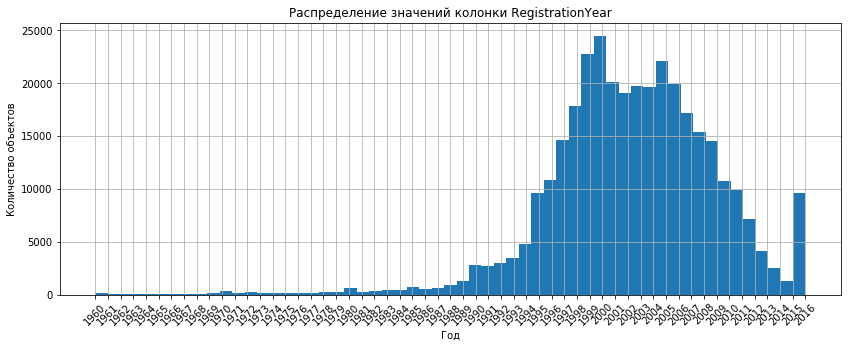

,RegistrationYear
count,339413.000000
mean,2002.549684
std,6.752072
min,1960.000000
25%,1999.000000
50%,2003.000000
75%,2007.000000
max,2016.000000


In [15]:
# распределение RegistrationYear
hist_describe(autos, 'RegistrationYear', 'Год', xticks=np.arange(1960, 2017), bins=autos['RegistrationYear'].nunique())

- Большинство предложений имеют дату регистрации с **1990 по 2010 год** (половина приходится на промежуток от 1999 до 2007 года).
- Автомобили с датой регистрации **до 1989 года** встречаются довольно **редко**.

### RegistrationMonth

In [16]:
# проверка аномальных значений
autos['RegistrationMonth'].value_counts()

0     33499
3     33170
6     30364
4     28173
5     28112
7     26256
10    25245
12    23392
11    23377
9     23071
1     22407
8     21813
2     20534
Name: RegistrationMonth, dtype: int64

- В датасете 13 месяцев, что выглядит неправдоподобно.
- Самым популярным значением является 0 месяц. Возможно, в нём скрыт **пропуск**.
- Можно допустить, что на цену влиют сезонные колебания цен. Однако для дальнейшей работы **удалим** эту колонку:

In [17]:
# удаление колонки RegistrationMonth
autos.drop('RegistrationMonth', axis=1, inplace=True)
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Price

Это целевой признак в нашей задаче - рассмотрим его распределение.

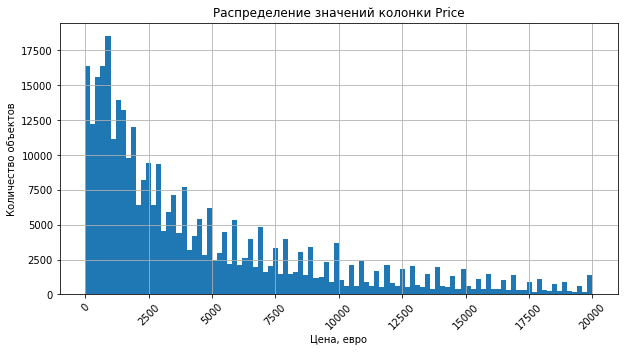

,Price
count,339413.000000
mean,4469.917885
std,4543.710777
min,0.000000
25%,1100.000000
50%,2799.000000
75%,6500.000000
max,20000.000000


In [18]:
# распределение Price
hist_describe(autos, 'Price', 'Цена, евро', bins=100, figsize=(10, 5))

- Данные распределены **не нормально**, распределение больше напоминает **экспоненциальное**: оно не унимодально, не симметрично.
- **Медиана** равна **2799 евро**, **среднее** равно **4470 евро**.
- Наблюдаются аномальные **нулевые** значения. Возможные причины:
 - Это **случайная** ошибка.
 - На самом деле это **пропуск**.
 - Машины действительно **ничего не стоят**, потому что в плохом состоянии, очень старые и др.
 
Если ознакомиться с объявлениями, например, российского рынка, самым дешёвым является предложение в **10 тыс. руб** - это старый автомобиль в очень плохом состоянии (подробнее - [сайт auto.ru](https://auto.ru/moskovskaya_oblast/cars/used/?price_to=10000)). Поэтому предложение **ниже 150 евро** кажется аномально дешёвым. Посмотрим, сколько всего таких объявлений:

In [19]:
print('Количество строк с нулевыми значениями:', len(autos.query('Price < 150')))
print('Доля от всех строк:', len(autos.query('Price < 150')) / len(autos))
autos.query('Price < 150').tail()

Количество строк с нулевыми значениями: 13938
Доля от всех строк: 0.04106501518798632


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
339285,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
339295,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
339323,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
339354,99,small,1999,manual,60,arosa,150000,petrol,seat,yes
339408,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes


В идеале наобходимо уточнить информацию, что означают **нулевые** значения и может ли быть в объявлениях стоимость **ниже 150 евро**.  
Поскольку она кажется **аномально низкой**, удалим её из рабочего датафрейма:

In [20]:
# удаление строк с аномально низкой ценой
print('Количество строк ДО:', len(autos))
autos = autos.query('Price >= 150')
print('Количество строк ПОСЛЕ:', len(autos))

Количество строк ДО: 339413
Количество строк ПОСЛЕ: 325475


### Power

В датасете представлена колонка *Power* - мощность в л.с. Изучим её значения. 

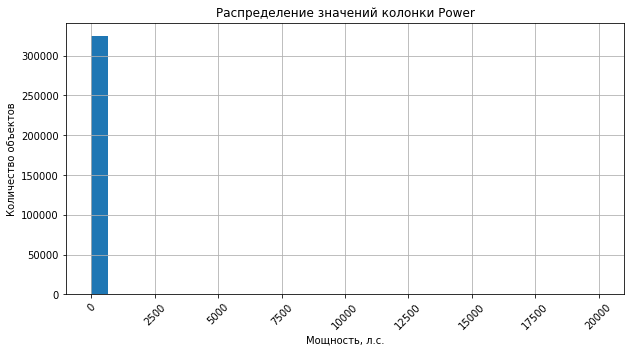

,Power
count,325475.000000
mean,112.651168
std,184.283225
min,0.000000
25%,73.000000
50%,105.000000
75%,143.000000
max,20000.000000


In [21]:
# распределение Power
hist_describe(autos, 'Power', 'Мощность, л.с.', bins=30, figsize=(10, 5))

- Гистограмма имеет такой вид из-за **аномально высоких** значений - **20 тыч. л.с.**. Для сравнения: один из мощнейних двигателей Bugatti способен генерировать **1500 л. с.** (подробнее - [Самый мощный гиперкар планеты во всех деталях](https://motor.ru/lab/chiron.htm)). Средняя мощность автомобилей в России - **117 л. с.** (подробнее - [Эксперты назвали среднюю мощность автомобилей в России](https://rg.ru/2019/10/18/reg-skfo/eksperty-nazvali-sredniuiu-moshchnost-avtomobilej-v-rossii.html)).

Выведем значения с мощностью **более 630 л.с.** (в качестве бенчмарка возьмём Мерседес S-Class, к-й может развивать до 630 л.с.):

In [22]:
# вывод аномально высоких значений
print('Количество строк: {}'.format(len(autos.query('Power > 630'))))
autos.query('Power > 630').head()

Количество строк: 301


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1734,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
3880,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5076,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
6198,3000,small,2009,manual,771,punto,125000,petrol,fiat,NaN
7304,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,NaN


- Таких значений немного - всего **301 строка**.
- Среди названий встречаются вполне обычные автомобили типа *opel astra* или *toyota corolla*, которые вряд ли могут развивать такую скорость. 

Также смущают **нулевые** и **очень маленькие** значения в мощности. Возможно, **нулевые** значения означают, что автомобиль **не работает**. 
Двигатель ВАЗ Ока вырабатывает 30 л. с. Будем считать, что **ниже 30 л. с.** значение кажется аномально низким:

In [23]:
# вывод аномально низких значений
print('Количество строк: {}'.format(len(autos.query('Power < 30'))))
autos.query('Power < 30').head()

Количество строк: 31666


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
29,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
34,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
49,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
50,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes


- Всего 35268 рядов с **аномально низкими** значениями - в реальной жизни следовало бы уточнить причину.

Удалим аномальны низкие и аномально высокие значения:

In [24]:
# удаление аномально низких значений
print('Количество строк ДО:', len(autos))
autos = autos.query('30 <= Power <= 630')
autos.reset_index(drop=True, inplace=True)
print('Количество строк ПОСЛЕ:', len(autos))

Количество строк ДО: 325475
Количество строк ПОСЛЕ: 293508


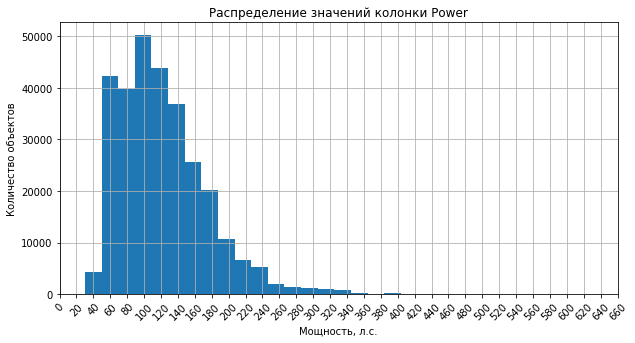

,Power
count,293508.000000
mean,121.127823
std,53.769880
min,30.000000
25%,77.000000
50%,113.000000
75%,150.000000
max,620.000000


In [25]:
# распределение Power
hist_describe(autos, 'Power', 'Мощность, л.с.', xticks=[i* 20 for i in range(34)], bins=30, figsize=(10, 5))

Теперь данные выглядят правдоподобно: в среднем мощность продаваемых автомобилей около **121 л. с.**

### Kilometer

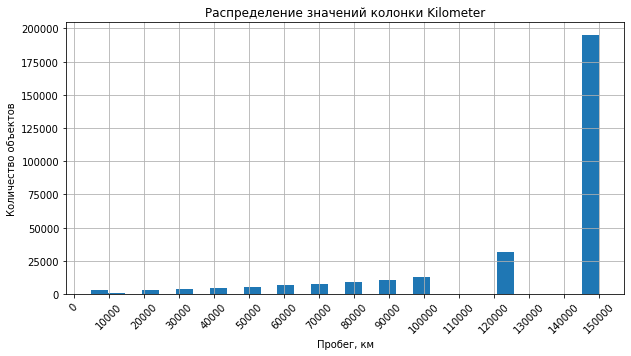

,Kilometer
count,293508.000000
mean,128448.849776
std,36540.786224
min,5000.000000
25%,125000.000000
50%,150000.000000
75%,150000.000000
max,150000.000000


In [26]:
# распределение Kilometer
hist_describe(autos, 'Kilometer', 'Пробег, км', xticks=[i*10**4 for i in range(16)], bins=30, figsize=(10, 5))

- Пробег в датафрейме округлён до тысячи км, в основном встречаются машины с пробегом **150 тыс. км**.
- **Максимальное** значение пробега - 150 тыс. км, **минимальное** - 5 тыс. км, т. е. новых машин без пробега нет.

Поскольку в колонке **нет аномальных значений** и **пропусков**, оставим все данные без изменений.

### Brand

Среди **брендов** изначально не было пропусков. Если бы они были, какую-то часть можно было бы восстановить исходя из **модели** автомобиля. Самым популярным брендом является *Volkswagen*:

In [27]:
# вывод топ-10 брендов
print('Количество уникальных брендов:', autos['Brand'].nunique())
autos['Brand'].value_counts(dropna=False).head(10)

Количество уникальных брендов: 40


volkswagen       63614
bmw              32126
opel             32120
mercedes_benz    27272
audi             25544
ford             20422
renault          13733
peugeot           9356
fiat              7453
seat              5802
Name: Brand, dtype: int64

Для ознакомления построим **боксплот** и выведем **сводную статистику** для топ-10 Брендов:

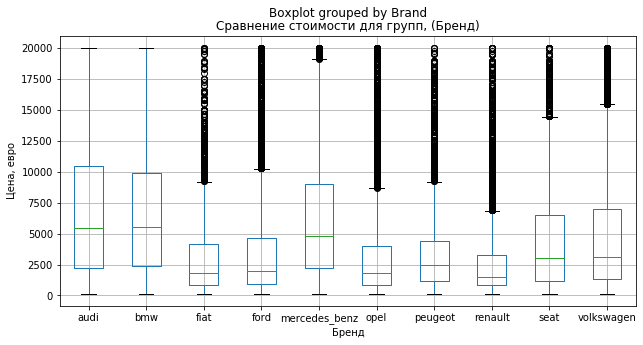

In [28]:
top10_brand = autos['Brand'].value_counts(dropna=False).head(10).index
autos.query('Brand in @top10_brand').boxplot('Price', by='Brand', figsize=(10, 5))
plt.title('Сравнение стоимости для групп, (Бренд)')
plt.xlabel('Бренд')
plt.ylabel('Цена, евро')
plt.show()

In [29]:
autos.query('Brand in @top10_brand').groupby('Brand')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Brand,,,,,,,,
audi,25544.0,6753.288130,5288.306779,150.0,2200.0,5450.0,10490.0,20000.0
bmw,32126.0,6640.604588,5040.953655,150.0,2400.0,5500.0,9900.0,20000.0
fiat,7453.0,2995.029921,3033.055399,150.0,850.0,1800.0,4199.0,20000.0
ford,20422.0,3562.808589,3972.845599,150.0,900.0,1999.0,4650.0,20000.0
mercedes_benz,27272.0,6338.038061,5070.321725,150.0,2250.0,4800.0,9000.0,20000.0
opel,32120.0,3074.113232,3315.111893,150.0,860.0,1800.0,4000.0,20000.0
peugeot,9356.0,3382.565306,3192.294240,150.0,1200.0,2494.5,4400.0,20000.0
renault,13733.0,2601.167407,2914.449161,150.0,850.0,1500.0,3250.0,20000.0
seat,5802.0,4426.433644,4119.248332,150.0,1200.0,2999.0,6500.0,20000.0


- Самые высокие выборочные средняя и медианная стоимость у брендов *Audi* и *BMW*.
- Для всех брендов из топ-10 есть предложения с **максимальной** стоимостью 20 тыс. евро.

### Model

In [30]:
# вывод топ-10 моделей
autos['Model'].value_counts(dropna=False).head(10)

golf        24535
other       20062
3er         17310
NaN         10697
polo        10518
corsa        9928
astra        9003
a4           8770
passat       8756
c_klasse     7314
Name: Model, dtype: int64

- Самой популярной моделью является *Volkswagen Golf*.
- На втором месте по популярности значение *Other* (т. е. другая модель машины).
- Также довольно часто встречаются строки **пропуски**. 

Поскольку у одного производителя *Brand* может быть несколько моделей, восстановить информацию может быть проблематично.  
В связи с этим мы **удалим** строки с пропусками:

In [31]:
def delete_before_after(df_name, col_name):
    """Функция удаляет пропуски из указанной колонки и выводит информацию о количество строк ДО и ПОСЛЕ:
     - df_name - название датафрейма;
     - col_name - название колонки (в кавычках)."""
    
    print('Количество строк ДО:', len(df_name))
    
    # удаление пропусков из указанной строки и сброс индексов
    df_name.dropna(subset=[col_name], inplace=True)
    df_name.reset_index(inplace=True, drop=True)
    
    print('Количество строк ПОСЛЕ:', len(df_name))
    return df_name

In [32]:
# удаление строк с пропусками Model
autos = delete_before_after(autos, 'Model')

Количество строк ДО: 293508
Количество строк ПОСЛЕ: 282811


### VehicleType

Напишем функцию, которая будет выводить количество строк по группам `value_counts()`, боксплот `.boxplot()` и сводную статистику `.describe()` по колонке с учётом разбивки по группам.

In [33]:
def valcount_sumstat_boxplot(df_name, col_name, group_by, box_title, box_xlabel, box_ylabel, box_yticks=None):
    
    """Функция возвращает количество строк по группам, боксплот и сводную статистику по колонке с учётом разбивки по группам.
    - df_name - название датафрейма;
    - col_name - рассматриваемая колонка;
    - group_by - колонка, по которой происходит разбивка по группам;
    - box_title - указать в именительном падеже название колонки;
    - box_xlabel - указать название оси x;
    - box_ylabel - указать название оси y;
    - box_yticks (необязательный параметр) - задать диапазон для оси y."""
        
    print(df_name[group_by].value_counts(dropna=False))
    
    boxplot = df_name.boxplot(col_name, by=group_by, figsize=(8, 5))
    plt.title('Сравнение стоимости для групп, (' + box_title + ')')
    plt.xlabel(box_xlabel)
    plt.ylabel(box_ylabel)
    plt.yticks(box_yticks)
    plt.show()
    
    sumstat = df_name.groupby(group_by)[col_name].describe()
    return sumstat

sedan          80053
small          66617
wagon          57362
bus            25432
convertible    17982
coupe          13787
suv            10310
NaN             9095
other           2173
Name: VehicleType, dtype: int64


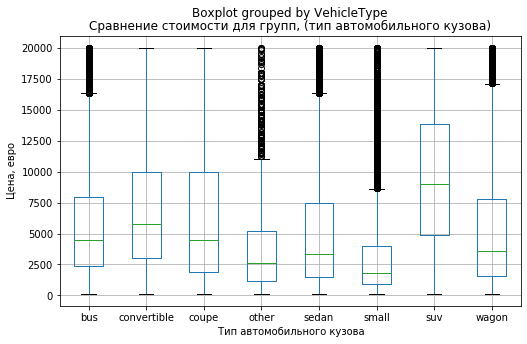

,count,mean,std,min,25%,50%,75%,max
VehicleType,,,,,,,,
bus,25432.0,5801.286489,4458.950668,150.0,2400.0,4500.0,7990.0,20000.0
convertible,17982.0,7093.153654,5061.468167,150.0,2999.0,5800.0,10000.0,20000.0
coupe,13787.0,6421.182708,5549.179605,150.0,1900.0,4450.0,9999.0,20000.0
other,2173.0,3966.430281,3935.753664,150.0,1200.0,2600.0,5200.0,19999.0
sedan,80053.0,5046.646359,4601.522583,150.0,1500.0,3380.0,7450.0,20000.0
small,66617.0,2952.750244,3066.678155,150.0,899.0,1799.0,3990.0,20000.0
suv,10310.0,9443.368671,5326.712318,150.0,4900.0,8990.0,13900.0,20000.0
wagon,57362.0,5244.812873,4635.612359,150.0,1599.0,3600.0,7800.0,20000.0


In [34]:
# колонка VehicleType
valcount_sumstat_boxplot(autos, 'Price', 'VehicleType', 'тип автомобильного кузова', ' Тип автомобильного кузова', 'Цена, евро')

- Наиболее популярный тип в выборке *sedan*;
- Наиболее низкая выборочная медианная стоимость и категории *small*, а наиболее высокая - у *suv*.
- В колонке присутствуют **пропуски** - **около 3%** (9095 строк).  
Можно было бы предположить, что **пропуск** означает **"другое (other)"**, но такой вариант ответа уже есть.

Чтобы не удалять эти строки, заменим пропуск в *VehicleType* **самым популярным ответом** для данной модели, т. е. **модой**.  
Напишем и протестируем соответствующую функцию:

In [35]:
def impute_mode(series):
    """Функция заменяет пропуск на моду для указанного Series."""
    try:
        return series.fillna(series.mode().iloc[0])
    except:
        return np.nan

Протестируем функцию на срезе:

In [36]:
# создание среза с 2-мя моделями
test_mode = autos.query('Model == "golf" or Model == "polo"').head(20)

# вывод самых популярных значений
print(test_mode.query('Model == "golf"')['VehicleType'].value_counts(dropna=False))
print()
print(test_mode.query('Model == "polo"')['VehicleType'].value_counts(dropna=False))

test_mode

sedan    8
small    4
NaN      2
bus      1
other    1
wagon    1
Name: VehicleType, dtype: int64

small    2
NaN      1
Name: VehicleType, dtype: int64


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
6,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
12,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
28,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no
44,1000,sedan,1998,manual,101,golf,150000,petrol,volkswagen,no
56,6600,sedan,2006,manual,105,golf,150000,gasoline,volkswagen,no
59,800,NaN,2000,manual,90,golf,150000,gasoline,volkswagen,NaN
88,6300,sedan,2002,manual,265,golf,150000,petrol,volkswagen,no
94,9290,small,2010,manual,86,polo,40000,petrol,volkswagen,no
98,1000,sedan,1990,manual,54,golf,150000,petrol,volkswagen,no


In [37]:
# проверка отработки функции
test_mode['VehicleType'] = test_mode.groupby('Model')['VehicleType'].transform(impute_mode)

# вывод самых популярных значений
print(test_mode.query('Model == "golf"')['VehicleType'].value_counts(dropna=False))
print()
print(test_mode.query('Model == "polo"')['VehicleType'].value_counts(dropna=False))

test_mode

sedan    10
small     4
bus       1
other     1
wagon     1
Name: VehicleType, dtype: int64

small    3
Name: VehicleType, dtype: int64


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
6,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
12,300,small,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
28,350,sedan,2016,manual,75,golf,150000,petrol,volkswagen,no
44,1000,sedan,1998,manual,101,golf,150000,petrol,volkswagen,no
56,6600,sedan,2006,manual,105,golf,150000,gasoline,volkswagen,no
59,800,sedan,2000,manual,90,golf,150000,gasoline,volkswagen,NaN
88,6300,sedan,2002,manual,265,golf,150000,petrol,volkswagen,no
94,9290,small,2010,manual,86,polo,40000,petrol,volkswagen,no
98,1000,sedan,1990,manual,54,golf,150000,petrol,volkswagen,no


В тестовом примере все пропуски были заменены на **моду** *VehicleType* модели автомобиля.  
Применим функцию к осномному датафрейму.

In [38]:
# выведем количество пропусков ДО
print('Количество пропусков ДО:', autos['VehicleType'].isnull().sum())

# заполним пропуски медианой по сгруппированным значениям
autos['VehicleType'] = autos.groupby('Model')['VehicleType'].transform(impute_mode)

# выведем количество пропусков ПОСЛЕ
print('Количество пропусков ПОСЛЕ:', autos['VehicleType'].isnull().sum())

Количество пропусков ДО: 9095
Количество пропусков ПОСЛЕ: 0


Функция отработала без ошибок, все пропуски для *VehicleType* были заменены на самый популярный ответ для соответствующей модели. 

### Gearbox

manual    221912
auto       56415
NaN         4484
Name: Gearbox, dtype: int64


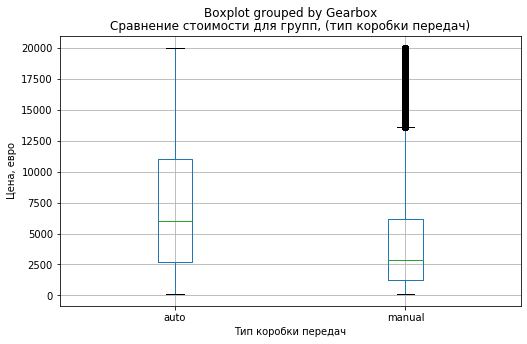

,count,mean,std,min,25%,50%,75%,max
Gearbox,,,,,,,,
auto,56415.0,7297.495241,5366.575294,150.0,2700.0,5999.0,11000.0,20000.0
manual,221912.0,4366.733192,4221.238035,150.0,1250.0,2850.0,6195.0,20000.0


In [39]:
# колонка Gearbox
valcount_sumstat_boxplot(autos, 'Price', 'Gearbox', 'тип коробки передач', 'Тип коробки передач', 'Цена, евро')

- В выборке чаще всего встречается ручная коробка передач *manual*.
- В среднем по выборке стоимость машины с автоматической коробкой передач **выше**, чем механической.
- Для 4484 строк тип коробки передач **пропущен**.

Одна и та же модель может иметь **разные типы коробок**. Однако если в датасете встречается только **одна коробка передач**, например, *manual*, мы можем заменить пропуск на это значение.

Проверим, какие модели имеют 1 тип коробки:

In [40]:
# проверка по моделям
for model_name in autos['Model'].unique():
    
    # срез для выбранной модели
    autos_slice = autos[autos['Model'] == model_name]
    
    # если у модели меньше 2 типов
    if autos_slice['Gearbox'].nunique() < 2:
        print(model_name, ': ', autos_slice['Gearbox'].unique())

fox :  ['manual' nan]
logan :  ['manual' nan]
duster :  ['manual' nan]
spark :  ['manual' nan]
niva :  ['manual' nan]
lodgy :  ['manual']
serie_2 :  ['manual']
doblo :  ['manual' nan]
145 :  ['manual']
range_rover_evoque :  ['auto']
gl :  ['auto']
kalina :  ['manual']
elefantino :  ['manual']
samara :  ['manual']
601 :  ['manual']
serie_3 :  ['manual']


Встречается всего **6 моделей** с пропусками и одним типом *Gearbox*, во всех случаях *manual*.  
Для этих моделей сделаем замену пропуска на *manual*:

In [41]:
model_list = ['fox', 'logan', 'duster', 'spark', 'niva', 'doblo']

for model_name in model_list:
    autos.loc[autos['Model'] == model_name, 'Gearbox'] = autos.loc[autos['Model'] == model_name, 'Gearbox'].fillna('manual')

In [42]:
# проверка по моделям
for model_name in autos['Model'].unique():
    
    # срез для выбранной модели
    autos_slice = autos[autos['Model'] == model_name]
    
    # если у модели меньше 2 типов
    if autos_slice['Gearbox'].nunique() < 2:
        print(model_name, ': ', autos_slice['Gearbox'].unique())

fox :  ['manual']
logan :  ['manual']
duster :  ['manual']
spark :  ['manual']
niva :  ['manual']
lodgy :  ['manual']
serie_2 :  ['manual']
doblo :  ['manual']
145 :  ['manual']
range_rover_evoque :  ['auto']
gl :  ['auto']
kalina :  ['manual']
elefantino :  ['manual']
samara :  ['manual']
601 :  ['manual']
serie_3 :  ['manual']


Замена на *manual* произведена успешно. Остальные строки с моделями, где может быть **два типа** коробки передач будут **удалены**:

In [43]:
# удаление строк с пропусками Gearbox
autos = delete_before_after(autos, 'Gearbox')

Количество строк ДО: 282811
Количество строк ПОСЛЕ: 278349


### FuelType

petrol      176831
gasoline     84831
NaN          11611
lpg           4357
cng            460
hybrid         178
other           47
electric        34
Name: FuelType, dtype: int64


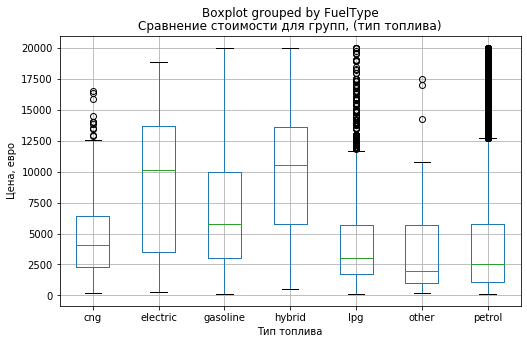

,count,mean,std,min,25%,50%,75%,max
FuelType,,,,,,,,
cng,460.0,4738.926087,3168.821584,199.0,2300.0,4050.0,6420.0,16500.0
electric,34.0,9088.235294,6076.022822,250.0,3525.0,10125.0,13687.5,18900.0
gasoline,84831.0,7024.963233,4942.961030,150.0,2999.0,5800.0,9999.0,20000.0
hybrid,178.0,9921.089888,4958.241324,500.0,5812.5,10545.0,13600.0,20000.0
lpg,4357.0,4169.717237,3394.932201,150.0,1700.0,3000.0,5700.0,20000.0
other,47.0,3910.127660,4179.296756,200.0,1000.0,2000.0,5699.5,17500.0
petrol,176831.0,4124.808258,4222.143053,150.0,1100.0,2499.0,5750.0,20000.0


In [44]:
# колонка FuelType
valcount_sumstat_boxplot(autos, 'Price', 'FuelType', 'тип топлива', 'Тип топлива', 'Цена, евро')

- Самым популярным видом топлива является *бензин (petrol)*.
- В колонке также присутствуют и **пропуски** и значение *Other*. Будем следовать логике c колонкой *GearBox* - если у данной модели только **один вид** топлива, делаем **замену пропуска** на это значение; если нет - **удалим** строки с пропусками.

In [45]:
# проверка по моделям
for model_name in autos['Model'].unique():
    
    # срез для выбранной модели
    autos_slice = autos[autos['Model'] == model_name]
    
    # если у модели меньше 2 типов
    if autos_slice['FuelType'].nunique() < 2:
        print(model_name, ': ', autos_slice['FuelType'].unique())

kadett :  [nan 'petrol']
r19 :  ['petrol' nan]
lanos :  ['petrol' nan]
boxster :  ['petrol' nan]
90 :  ['petrol' nan]
911 :  ['petrol' nan]
charade :  ['petrol' nan]
9000 :  ['petrol' nan]
200 :  ['petrol' nan]
145 :  ['petrol' nan]
move :  ['petrol' nan]
range_rover_evoque :  ['gasoline']
materia :  ['petrol']
gl :  ['gasoline']
elefantino :  ['petrol' nan]
amarok :  ['gasoline']
601 :  ['petrol']


Встречается всего **12 моделей** с пропусками и одним типом *FuelType*, во всех случаях *petrol*.  
Для этих моделей сделаем замену пропуска на *petrol*:

In [46]:
model_list = ['kadett', 'r19', 'lanos', 'boxster', '90', '911', 'charade', '9000', '200', '145', 'move', 'elefantino']

for model_name in model_list:
    autos.loc[autos['Model'] == model_name, 'FuelType'] = autos.loc[autos['Model'] == model_name, 'FuelType'].fillna('petrol')

In [47]:
# проверка по моделям
for model_name in autos['Model'].unique():
    
    # срез для выбранной модели
    autos_slice = autos[autos['Model'] == model_name]
    
    # если у модели меньше 2 типов
    if autos_slice['FuelType'].nunique() < 2:
        print(model_name, ': ', autos_slice['FuelType'].unique())

kadett :  ['petrol']
r19 :  ['petrol']
lanos :  ['petrol']
boxster :  ['petrol']
90 :  ['petrol']
911 :  ['petrol']
charade :  ['petrol']
9000 :  ['petrol']
200 :  ['petrol']
145 :  ['petrol']
move :  ['petrol']
range_rover_evoque :  ['gasoline']
materia :  ['petrol']
gl :  ['gasoline']
elefantino :  ['petrol']
amarok :  ['gasoline']
601 :  ['petrol']


Замена на *petrol* произведена успешно. Остальные строки с моделями, где может быть **несколько типов** топлива **удалим**:

In [48]:
# удаление строк с пропусками FuelType
autos = delete_before_after(autos, 'FuelType')

Количество строк ДО: 278349
Количество строк ПОСЛЕ: 266797


### NotRepaired

Данная колонка означает, была ли машина в ремонте.

no     209883
NaN     32406
yes     24508
Name: NotRepaired, dtype: int64


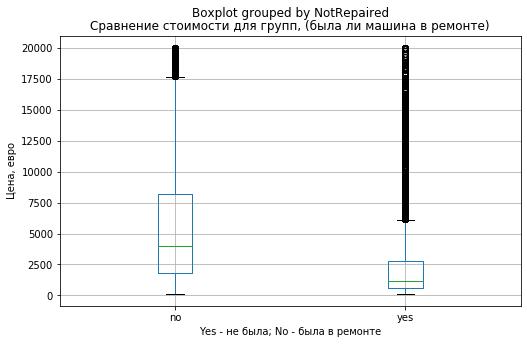

,count,mean,std,min,25%,50%,75%,max
NotRepaired,,,,,,,,
no,209883.0,5635.562785,4773.182655,150.0,1850.0,4000.0,8199.0,20000.0
yes,24508.0,2307.313571,2883.275755,150.0,600.0,1200.0,2800.0,20000.0


In [49]:
# колонка NotRepaired
valcount_sumstat_boxplot(autos, 'Price', 'NotRepaired', 'была ли машина в ремонте',
                         'Yes - не была; No - была в ремонте', 'Цена, евро')

Предполагается, что на вопрос "*NotRepaired (Не была в ремонте)*" ответ "*Yes*" означает "*Да, не была в ремонте*".

По боксплотам кажется, как будто автомобили, которые **не были в ремонте** в среднем стоят **дешевле**, что кажется не совсем логичным. Возможно, есть путаница в формулировке вопроса. Либо речь идёт о более дешёвых марках автомобилей, что и отражается на цене.

Для нашей текущей задачи ответ не так важен - основная суть в том, что он будет выступать в качестве признака.

Поскольку **пропусков** очень много (порядка 12%), не будем удалять строки, а сделаем замену на значение *unknown*.

In [50]:
# замена пропусков на unknown
autos['NotRepaired'] = autos['NotRepaired'].fillna('unknown')
print('Количество строк:', len(autos))

Количество строк: 266797


## 1.2. Вывод

- Для дальнейшего обучения были **удалены** следующие **колонки**:
 - Колонки, связанные с **датами**: *DateCrawled*, *DateCreated*, *LastSeen*.
 - Колонка *PostalCode* - почтовый индекс.
 - Колонка *NumberOfPictures* - количество фотографий, в колонке было только одно значение 0.
 - Колонка *RegistrationMonth* - месяц регистрации. Всего в колонке 13 месяцев, самым популярным был "нулевой" месяц - возможно, это означало отсутствие информации.
 
   
- Были удалены **строки** в следующих **колонках**:
 - Колонка *RegistrationYear* - год регистрации, обнаружены неправдоподобные значения в виде аномально старых годов (1000, 1800 год) и годов из будущего (2017, 2018 год). Строки с аномальными годами удалены.
 - Колонка *Price* - есть **нулевые** и **аномально низкие** значения. В идеале, нужно определить, что означает 0 (пропуск; машина действительно ничего не стоит и др.). Для дальнейшей работы мы удалили строки со значением **меньше 150 евро**.
 - Колонка *Power* - удалены **аномально низкие** (меньше 30 л. с.) и **аномально высокие** (больше 630 л. с.) значения.
 - Колонка *Model* - у одного производителя может быть несколько моделей; в связи с этим удалены все строки с пропусками.
 - Колонки *VehicleType* - пропуск заменён самым популярным ответом для данной модели.
 - Колонки *Gearbox*, *FuelType* - если у модели **только один** тип топлива, пропуск был заменён на это значение.


- Для колонки *NotRepaired* пропуски заменены на значение **unknown**.

### 1.3. Подготовка данных для обучения

Для обучения мы планируем сравнить несколько моделей: *RandomForest*, *LightGBM* и *CatBoost*. Для *RandomForest* потребуется кодирование данных. 

Выделим **признаки** и **целевой признак**, к-е будут использоваться при обучении модели.

In [51]:
# выделение целевого признака
y = autos['Price']
# выделение признаков
X = autos.drop('Price', axis=1)
# проверка значений
X.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
1,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


**Закодируем** категориальные данные в **количественные**, чтобы иметь возможность использовать модель *RandomForest*.  
В данном случае подойдёт техника **Ordinal Encoding**. Также выделим **обучающую** и **тестовую** выборку в пропорции 70 на 30.

In [53]:
SEED = 876

# кодирование и разделение на выборки
encoder = OrdinalEncoder()

X = pd.DataFrame(encoder.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
print('Всего объектов в выборке:', len(autos))
print('Количество объектов в обучающей выборке:', len(X_train))
print('Количество объектов в тестовой выборке:', len(X_test))
X_train.head()

Всего объектов в выборке: 266797
Количество объектов в обучающей выборке: 186757
Количество объектов в тестовой выборке: 80040


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
229426,7.0,51.0,1.0,75.0,170.0,12.0,2.0,37.0,0.0
12353,7.0,42.0,0.0,101.0,170.0,12.0,2.0,37.0,0.0
250778,5.0,41.0,1.0,30.0,173.0,12.0,6.0,37.0,0.0
20775,4.0,41.0,1.0,75.0,174.0,12.0,6.0,23.0,0.0
126670,0.0,42.0,1.0,79.0,212.0,12.0,2.0,20.0,0.0


Для **количественных** переменных сделаем **масштабирование**:

In [54]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

# создание образца модели и обучение
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
229426,7.0,1.304431,1.0,-0.317013,170.0,0.521996,2.0,37.0,0.0
12353,7.0,-0.164500,0.0,0.176842,170.0,0.521996,2.0,37.0,0.0
250778,5.0,-0.327715,1.0,-1.171763,173.0,0.521996,6.0,37.0,0.0
20775,4.0,-0.327715,1.0,-0.317013,174.0,0.521996,6.0,23.0,0.0
126670,0.0,-0.164500,1.0,-0.241036,212.0,0.521996,2.0,20.0,0.0


## 1.3. Вывод

- Выделены **признаки** и **целевой признак** для дальнейшего обучения.
- Проведено разделение данных на **обучающую** и **тестовую** выборку.
- Для использования в некоторых моделях проведено **кодирование** категориальных переменных.
- Для **количественных** переменных проведено **масштабирование**.

## Шаг 1. Вывод

- **1.1. Открытие файла**
 - В исходных данных содержалось **354369 строк и 16 столбцов**. 
 - Присутствуют как **категориальные**, так и **количественные** переменные. 
 - В 5 колонках присутствуют **пропуски**: *VehicleType*, *Gearbox*, *Model*, *FuelType*, *NotRepaired*.
 - Было обнаружено и удалено **4 дубликата**. 

    
- **1.2. Проверка и изучение данных**
 - Для дальнейшего обучения были удалены следующие колонки: *DateCrawled*, *DateCreated*, *LastSeen* (колонки с датами); *PostalCode* (почтовый индекс); *NumberOfPictures* (количество фотографий); *RegistrationMonth* (месяц регистрации).
 - Были удалены **аномально низкие** и **аномально высокие** значения в колонках *RegistrationYear*, *Price*, *Power*.
 - Полностью удалены пропуски в *Model*.
 - Пропуски заменены **модой** в *VehicleType*.
 - В колонках *Gearbox*, *FuelType* при наличии **одного** типа коробки передач или топлива, пропуск заменялся **соответствующим значением**.
 - Для колонки *NotRepaired* пропуски заменены на значение **unknown**.
   
   
- **1.3. Подготовка данных для обучения**
 - Выделены **признаки** и **целевой признак** для дальнейшего обучения.
 - Проведено разделение данных на **обучающую** и **тестовую** выборку.
 - Для использования в некоторых моделях проведено **кодирование** категориальных переменных.
 - Для **количественных** переменных проведено **масштабирование**.

## Шаг 2. Обучение моделей

В данном пункте мы обучим несколько моделей:
- *RandomForest* - модель **случайного леса**;
- *CatBoost, LightGBM* - модели **градиентного бустинга**.

Данный шаг раделим на следующие пункты:
- [2.1. Константная модель](#2.1.-Константная-модель)
- [2.2. Случайный лес (RandomForestRegressor)](#2.2.-Случайный-лес-(RandomForestRegressor))
- [2.3. Градиентный бустинг (CatBoost)](#2.3.-Градиентный-бустинг-(CatBoost))
- [2.4. Градиентный бустинг (LightGBM)](#2.4.-Градиентный-бустинг-(LightGBM))

Напишем функцию, которая будем выводить **предсказанные и рельные** значения, а также **значение RMSE**:

In [56]:
def pred_target_RMSE(target_val, pred_val):    
    """Функция выводит на экран предсказанные и рельные значения, а также значение RMSE:
    - target_val - реальные целевые значения;
    - pred_val - предсказанные значения."""
    
    # расчёт метрик
    RMSE = np.sqrt(mean_squared_error(target_val, pred_val))
    
    # вывод информации
    print('Предсказания модели:')
    print(pred_val)
    print('Реальные значения:')
    print(target_val.values)
    print('Значение RMSE:', RMSE)

### 2.1. Константная модель

Посмотрим, какие результаты получатся при замене предсказаний **константой**. В качестве **константы** выберем **среднее** и **медиану**:

In [57]:
%%time
# константа - среднее
mean_const = pd.Series(y.mean(), index=y.index)
pred_target_RMSE(y, mean_const.values)

Предсказания модели:
[5052.67298358 5052.67298358 5052.67298358 ... 5052.67298358 5052.67298358
 5052.67298358]
Реальные значения:
[9800 1500 3600 ... 1199 9200 3400]
Значение RMSE: 4653.541220566577
Wall time: 5.98 ms


Предсказания модели:
[5270.90557022 5270.90557022 5270.90557022 ... 5270.90557022 5270.90557022
 5270.90557022]
Реальные значения:
[1500 3600  650 ... 3200 1199 9200]
Значение MSE: 22226625.90897163
Значение RMSE: 4714.512266287111
CPU times: user 7.08 ms, sys: 3.99 ms, total: 11.1 ms
Wall time: 8.95 ms


In [64]:
%%time
# константа - среднее
# датафрейм autos_ukn
mean_const_ukn = pd.Series(y_ukn.mean(), index=y_ukn.index)
pred_target_MSE_RMSE(y_ukn, mean_const_ukn.values)

Предсказания модели:
[5028.43698631 5028.43698631 5028.43698631 ... 5028.43698631 5028.43698631
 5028.43698631]
Реальные значения:
[9800 1500 3600 ... 1199 9200 3400]
Значение MSE: 21530085.668250028
Значение RMSE: 4640.052334645594
CPU times: user 4.05 ms, sys: 4.03 ms, total: 8.08 ms
Wall time: 5.89 ms


In [65]:
%%time
# константа - медиана
# датафрейм autos
median_const = pd.Series(y.median(), index=y.index)
pred_target_MSE_RMSE(y, median_const.values)

Предсказания модели:
[3650. 3650. 3650. ... 3650. 3650. 3650.]
Реальные значения:
[1500 3600  650 ... 3200 1199 9200]
Значение MSE: 24853960.77654285
Значение RMSE: 4985.374687678234
CPU times: user 13.5 ms, sys: 3.94 ms, total: 17.4 ms
Wall time: 14.4 ms


In [66]:
%%time
# константа - медиана
# датафрейм autos_ukn
median_const_ukn = pd.Series(y_ukn.median(), index=y_ukn.index)
pred_target_MSE_RMSE(y_ukn, median_const_ukn.values)

Предсказания модели:
[3400. 3400. 3400. ... 3400. 3400. 3400.]
Реальные значения:
[9800 1500 3600 ... 1199 9200 3400]
Значение MSE: 24181892.686637115
Значение RMSE: 4917.508788669026
CPU times: user 7.18 ms, sys: 8.19 ms, total: 15.4 ms
Wall time: 12.8 ms


- В случае константной модели со **средним** **RMSE** равно **4714.5** (autos) и **4640.0** (autos_ukn), т. е. в среднем модель ошибается на 4600-4700 евро.
- В случае константной модели с **медианой** **RMSE** равно **4985.4** (autos) и **4917.5** (autos_ukn), т. е. хуже, чем при среднем.

Таким образом, если при обучении RMSE будет **больше 4600 евро**, это говорит о том, что предсказания **хуже**, чем у константной модели.

Также отдельно заметим, что **время**, затраченное на обучение, составляло **меньше 1 секунды**. При этом важно отметить, что **Wall-time** может отличаться от замера к замеру.

Для удобства зафиксируем информацию в таблице и на **Шаге 3** проведём анализ полученных метрик и замеров времени.

In [67]:
# создание таблицы
total_info = pd.DataFrame({'Model name': ['Constant (mean)', 'Constant (median)'],
                           'params_tuning': ['-', '-'],
                           'autos, RMSE': [4714.5, 4985.4],
                           'autos, wall-time': ['00:00:01', '00:00:01'],
                           'autos_ukn, RMSE': [4640.0, 4917.5],
                           'autos_ukn, wall-time': ['00:00:01', '00:00:01']
                           
                          })
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01


<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
хорошо) Это - по человечески:) - выведение результата в таблицу.

## 2.1. RandomForest

Для экономии времени возьмём **небольшие значения параметров** и рассчитаем значения **MSE** и **RMSE**.  
Напомним, что для Случайного Леса мы будем пользоваться **закодированными** данными.

Напишем функцию для обучения модели:

In [68]:
def train_randfor(X_train_val, y_train_val, X_test_val, y_test_val, n_estimators=None, max_depth=None):
    """Обучение с использованием модели случайного леса:
    - X_train_val - обучающие признаки;
    - y_train_val - обучающий целевой признак;
    - X_test_val - тестовые признаки;
    - y_test_val - тестовый целевой признак;
    - n_estimators - параметр n_estimators;
    - max_depth - параметр max_depth."""
    
    # создание модели   
    randfor = RandomForestRegressor(random_state=SEED, n_estimators=n_estimators, max_depth=max_depth)
    
    # обучение модели
    randfor.fit(X_train_val, y_train_val)
    
    # предсказания модели
    randfor_pred_test_val = randfor.predict(X_test_val)
    
    # вывод информации
    return pred_target_MSE_RMSE(y_test_val, randfor_pred_test_val)

In [69]:
%%time
# датафрейм autos
train_randfor(X_train_C, y_train_C, X_test_C, y_test_C, n_estimators=50, max_depth=6)

Предсказания модели:
[8527.44133883 2557.3041427  2678.26199932 ... 6810.32010246 3771.34983109
 2145.19553691]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 8045536.039931293
Значение RMSE: 2836.4654131385582
CPU times: user 8.14 s, sys: 18.3 ms, total: 8.16 s
Wall time: 8.18 s


In [70]:
%%time
# датафрейм autos_ukn
train_randfor(X_train_ukn_C, y_train_ukn_C, X_test_ukn_C, y_test_ukn_C, n_estimators=50, max_depth=6)

Предсказания модели:
[ 3974.29464914  5748.78225866  8530.97836408 ...  4087.32131243
  8694.25739924 10890.03748455]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 7845280.134291463
Значение RMSE: 2800.9427224224814
CPU times: user 11.2 s, sys: 14.5 ms, total: 11.2 s
Wall time: 11.3 s


Для гиперпараметров `n_estimators=50`, `max_depth=6`:
- В датафрейме `autos`:
 - **RMSE** равно **2836.5**.
 - **Wall-time** равно **7.15 s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2800.9**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **9.04 s**.

Создадим функцию для добавления новых рядов с замерами по моделям:

In [71]:
def add_new_row(df_name, model_name, params_tuning, autos_RMSE, autos_time, autos_ukn_RMSE, autos_ukn_time):
    
    """Функция добавляет новый ряд с измеренными показателями для модели:
    - model_name - название модели;
    - params_tuning - настраиваемые гиперпараметры;
    - autos_RMSE - RMSE, датафрейм autos;
    - autos_time - замеренное время, датафрейм autos;
    - autos_ukn_RMSE- RMSE, датафрейм autos_ukn;
    - autos_ukn_time - замеренное время, датафрейм autos_ukn."""
    
    # создание нового ряда
    new_row = pd.DataFrame(
        data=[[model_name, params_tuning, autos_RMSE, autos_time, autos_ukn_RMSE, autos_ukn_time]],
        columns=total_info.columns)
    
    # добавление нового ряда
    df_name = df_name.append(new_row)
    df_name = df_name.reset_index(drop=True)
    return df_name

In [72]:
total_info = add_new_row(total_info, 'Random forest', 'n_estimators=50, max_depth=6', 2836.5, '00:00:07', 2800.9, '00:00:09')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09


Если выбрать большее число `n_estimators`, то можно ожидать, что предсказания будут **точнее**, но и времени на работу будет потрачено **больше**. Проверим это:

In [73]:
%%time
# датафрейм autos
train_randfor(X_train_C, y_train_C, X_test_C, y_test_C, n_estimators=200, max_depth=8)

Предсказания модели:
[7838.77255412 2335.78223145 2524.44624783 ... 7423.25246424 4043.36841487
 1906.77680227]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 7061147.520769264
Значение RMSE: 2657.281979912795
CPU times: user 43.1 s, sys: 9.1 ms, total: 43.1 s
Wall time: 43.3 s


In [74]:
%%time
# датафрейм autos_ukn
train_randfor(X_train_ukn_C, y_train_ukn_C, X_test_ukn_C, y_test_ukn_C, n_estimators=200, max_depth=8)

Предсказания модели:
[2941.37386979 5158.60091139 8377.89735622 ... 4132.92305783 8443.89222895
 9882.92843907]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 6935541.36418171
Значение RMSE: 2633.541600996975
CPU times: user 1min 18s, sys: 82.6 ms, total: 1min 18s
Wall time: 1min 19s


Для гиперпараметров `n_estimators=200`, `max_depth=8`:
- В датафрейме `autos`:
 - **RMSE** равно **2657.3**.
 - **Wall-time** равно **36.9 s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2633.5**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **43.2 s**.

In [75]:
total_info = add_new_row(total_info, 'Random forest', 'n_estimators=200, max_depth=8', 2657.3, '00:00:37', 2633.5, '00:00:43')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43


Как мы и предполагали, с увеличением параметров `n_estimators` и `max_depth`, метрика **RMSE снизилась**, т. е. предсказния стали лучше, но при этом **увеличилось** время **работы**.

## 2.2. CatBoost

Поскольку модель умеет работать с **категориальными** переменными, будем использовать незакодированные данные.  
Сначала не будем ограничивать модель и посмотрим на результат. ***ВНИМАНИЕ! Время отработки кода более 7 минут!*** 

Напишем функцию для обучения модели, указав параметры **по умолчанию** из документации, за исключением:
- Для удобства укажем `verbose=50`;
- Поскольку гиперпараметры `iterations` и `n_estimators` конфликтуют, для `n_estimators` укажем значение по умолчанию **None**.

In [76]:
def train_cat_reg(X_train_val, y_train_val, X_test_val, y_test_val, verbose=50,
                  learning_rate=0.03, iterations=1000, n_estimators=None, max_depth=6):
    """Обучение с использованием модели градиентного бустинга CatBoost:
    - X_train_val - обучающие признаки;
    - y_train_val - обучающий целевой признак;
    - X_test_val - тестовые признаки;
    - y_test_val - тестовый целевой признак;
    - verbose (по умолчанию 50) - шаг для выведения строк;
    - learning_rate - параметр learning_rate;
    - iterations - параметр iterations;
    - n_estimators - параметр n_estimators;
    - max_depth - параметр max_depth."""
    
    # создание модели   
    cat_reg = CatBoostRegressor(random_state=SEED, 
                                learning_rate=learning_rate, iterations=iterations,
                                n_estimators=n_estimators, max_depth=max_depth)
    
    # выделение категориальных признаков
    cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
    
    # обучение модели
    cat_reg.fit(X_train_val, y_train_val, cat_features=cat_features, verbose=verbose)
    
    # предсказания модели
    cat_pred_test_val = cat_reg.predict(X_test_val)
    
    # вывод информации
    return pred_target_MSE_RMSE(y_test_val, cat_pred_test_val)

Сначала не будем ограничивать модель и посмотрим на результат. ***ВНИМАНИЕ! Время отработки кода более 7 минут!*** 

In [77]:
%%time
# датафрейм autos
train_cat_reg(X_train, y_train, X_test, y_test)

0:	learn: 4635.4340135	total: 534ms	remaining: 8m 53s
50:	learn: 2950.8752038	total: 22.4s	remaining: 6m 56s
100:	learn: 2686.3157713	total: 43.1s	remaining: 6m 24s
150:	learn: 2601.5395488	total: 1m 4s	remaining: 6m 2s
200:	learn: 2557.7520754	total: 1m 25s	remaining: 5m 39s
250:	learn: 2527.0305670	total: 1m 45s	remaining: 5m 15s
300:	learn: 2504.5741943	total: 2m 5s	remaining: 4m 51s
350:	learn: 2481.5037170	total: 2m 26s	remaining: 4m 31s
400:	learn: 2455.6216381	total: 2m 49s	remaining: 4m 12s
450:	learn: 2434.5718849	total: 3m 11s	remaining: 3m 53s
500:	learn: 2414.5387499	total: 3m 35s	remaining: 3m 34s
550:	learn: 2396.9350243	total: 3m 57s	remaining: 3m 13s
600:	learn: 2380.3243855	total: 4m 21s	remaining: 2m 53s
650:	learn: 2367.3374578	total: 4m 42s	remaining: 2m 31s
700:	learn: 2355.2704875	total: 5m 4s	remaining: 2m 9s
750:	learn: 2344.7534269	total: 5m 26s	remaining: 1m 48s
800:	learn: 2334.3256650	total: 5m 47s	remaining: 1m 26s
850:	learn: 2323.9358204	total: 6m 10s	rem

In [78]:
%%time
# датафрейм autos_ukn
train_cat_reg(X_train_ukn, y_train_ukn, X_test_ukn, y_test_ukn)

0:	learn: 4569.1155502	total: 673ms	remaining: 11m 11s


KeyboardInterrupt: 

При обучении **без ограничения** гиперпараметров, результаты CatBoost:
- В датафрейме `autos`:
 - **RMSE** равно **2307.7**.
 - **Wall-time** равно **7min 5s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2285.7**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **9min 19s**.
 
Таким образом, результаты стали гораздо **лучше**, но при этом и значительно увеличилось время обучения.

In [79]:
total_info = add_new_row(total_info, 'CatBoost', 'default', 2307.7, '00:07:05', 2285.7, '00:09:19')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19


Теперь ограничим некоторые гиперпараметры модели. Например, **увеличим** `learning_rate`, чтобы шаг модели был шире, и **снизим** число итераций `iterations`. При такой настройке модель должна обучаться **быстрее**.


Выберем значения `learning_rate=0.3`, `iterations=300`:

In [80]:
%%time
# датафрейм autos
train_cat_reg(X_train, y_train, X_test, y_test, learning_rate=0.3, iterations=300)

0:	learn: 3995.7556970	total: 467ms	remaining: 2m 19s
50:	learn: 2421.7300390	total: 24.7s	remaining: 2m
100:	learn: 2313.4487333	total: 47.3s	remaining: 1m 33s


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1307, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 2, in <module>
  File "<ipython-input-76-05d748cdccde>", line 23, in train_cat_reg
    cat_reg.fit(X_train_val, y_train_val, cat_features=cat_features, verbose=verbose)
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 4330, in fit
    save_snapshot, snapshot_file, snapshot_interval, init_model)
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 1690, in _fit
    train_params["init_model"]
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 1225, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 3870, in _catboost._CatBoost._train
  File "_catboost.pyx", line 3916, in _catboost._CatBoost._train
KeyboardInterrupt

During handl

TypeError: object of type 'NoneType' has no len()

In [ ]:
%%time
# датафрейм autos_ukn
train_cat_reg(X_train_ukn, y_train_ukn, X_test_ukn, y_test_ukn, learning_rate=0.3, iterations=300)

Для гиперпараметров `learning_rate=0.3`, `iterations=300`:
- В датафрейме `autos`:
 - **RMSE** равно **2176.3**.
 - **Wall-time** равно **2min 17s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2166.8**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **2min 55s**.
    
По сравнению с настройками по умолчанию, результаты стали **лучше**, и время обучения **снизилось**.

In [ ]:
total_info = add_new_row(total_info, 'CatBoost', 'learning_rate=0.3, iterations=300', 2176.3, '00:02:17', 2166.8, '00:02:55')
total_info

Проверим ещё одну настройку: снова увеличим `learning_rate`, а также увеличим и `iterations`.  
Выберем значения `learning_rate=0.7`, `iterations=500`:

In [85]:
%%time
# датафрейм autos
train_cat_reg(X_train, y_train, X_test, y_test, learning_rate=0.7, iterations=500)

0:	learn: 3326.3493700	total: 460ms	remaining: 3m 49s
50:	learn: 2304.9149510	total: 21.4s	remaining: 3m 8s
100:	learn: 2202.0812339	total: 42.1s	remaining: 2m 46s
150:	learn: 2139.9884754	total: 1m 3s	remaining: 2m 27s
200:	learn: 2098.3041317	total: 1m 24s	remaining: 2m 6s
250:	learn: 2062.6695725	total: 1m 46s	remaining: 1m 46s
300:	learn: 2033.5402568	total: 2m 7s	remaining: 1m 24s
350:	learn: 2019.0442840	total: 2m 28s	remaining: 1m 3s
400:	learn: 2003.8074351	total: 2m 49s	remaining: 41.9s
450:	learn: 1987.6695292	total: 3m 11s	remaining: 20.8s
499:	learn: 1972.8697626	total: 3m 32s	remaining: 0us
Предсказания модели:
[7567.37027055  902.67962203 2102.96621217 ... 6781.91490994 4864.76353581
 7200.72834118]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 4438347.536125972
Значение RMSE: 2106.7386017553226
CPU times: user 3min 11s, sys: 22.7 s, total: 3min 33s
Wall time: 3min 36s


In [86]:
%%time
# датафрейм autos_ukn
train_cat_reg(X_train_ukn, y_train_ukn, X_test_ukn, y_test_ukn, learning_rate=0.7, iterations=500)

0:	learn: 3291.1189126	total: 618ms	remaining: 5m 8s
50:	learn: 2309.5896748	total: 28.8s	remaining: 4m 13s
100:	learn: 2191.1801869	total: 56.8s	remaining: 3m 44s
150:	learn: 2129.3847076	total: 1m 25s	remaining: 3m 18s
200:	learn: 2086.7455203	total: 1m 54s	remaining: 2m 50s
250:	learn: 2057.8632041	total: 2m 22s	remaining: 2m 21s
300:	learn: 2033.6676287	total: 2m 51s	remaining: 1m 53s
350:	learn: 2015.0827250	total: 3m 18s	remaining: 1m 24s
400:	learn: 1995.8751046	total: 3m 49s	remaining: 56.6s
450:	learn: 1979.2806030	total: 4m 16s	remaining: 27.9s
499:	learn: 1963.0098028	total: 4m 45s	remaining: 0us
Предсказания модели:
[  612.80615705  5142.80893534  8479.7253904  ...  3274.87237037
  6827.34162463 11317.77303452]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 4397310.122086986
Значение RMSE: 2096.9764238271696
CPU times: user 4min 20s, sys: 26.8 s, total: 4min 47s
Wall time: 4min 49s


Для гиперпараметров `learning_rate=0.07`, `iterations=500`:
- В датафрейме `autos`:
 - **RMSE** равно **2106.7**.
 - **Wall-time** равно **3min 36s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2097.0**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **4min 49s**.
    
Увеличение гиперпараметров **снизило скорость**, но **повысило качество** модели.

In [168]:
total_info = add_new_row(total_info, 'CatBoost', 'learning_rate=0.7, iterations=500', 2106.7, '00:03:36', 2097.0, '00:04:49')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19
5,CatBoost,"learning_rate=0.3, iterations=300",2176.3,00:02:17,2166.8,00:02:55
6,CatBoost,"learning_rate=0.7, iterations=500",2106.7,00:03:36,2097.0,00:04:49


Для сравнения мы можем оценить работу модели и при **других гиперпараметрах**, например, `n_estimators`, `max_depth`.  
Выберем значения `n_estimators=50`, `max_depth=6` (те же параметры мы выбирали для случайного леса):

In [89]:
%%time
# датафрейм autos
train_cat_reg(X_train, y_train, X_test, y_test, n_estimators=50, max_depth=6, iterations=None)

0:	learn: 4634.9761647	total: 133ms	remaining: 6.51s
49:	learn: 2971.9622411	total: 11.4s	remaining: 0us
Предсказания модели:
[7059.27926536 2984.28643223 2789.02830385 ... 5934.08547237 3947.04886533
 3578.87773132]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 8849204.07381467
Значение RMSE: 2974.761179290645
CPU times: user 10.8 s, sys: 1.5 s, total: 12.3 s
Wall time: 13.5 s


In [90]:
%%time
# датафрейм autos_ukn
train_cat_reg(X_train_ukn, y_train_ukn, X_test_ukn, y_test_ukn, n_estimators=50, max_depth=6, iterations=None)

0:	learn: 4568.9061778	total: 279ms	remaining: 13.7s
49:	learn: 2944.0630186	total: 13.9s	remaining: 0us
Предсказания модели:
[3271.29186924 3834.74998769 7134.20761967 ... 4837.31443267 7597.19048337
 7427.9591245 ]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 8599097.864106603
Значение RMSE: 2932.421842795917
CPU times: user 13.7 s, sys: 1.54 s, total: 15.3 s
Wall time: 16.3 s


Для гиперпараметров `n_estimators=50`, `max_depth=6`:
- В датафрейме `autos`:
 - **RMSE** равно **2974.8**.
 - **Wall-time** равно **13.5 s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2932.4**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **16.3 s**.
    
При таких гиперпараметрах результат RMSE **хуже**, чем у случайного леса. Также была **ниже** и **скорость** обучения.

In [169]:
total_info = add_new_row(total_info, 'CatBoost', 'n_estimators=50, max_depth=6', 2974.8, '00:00:14', 2932.4, '00:00:16')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19
5,CatBoost,"learning_rate=0.3, iterations=300",2176.3,00:02:17,2166.8,00:02:55
6,CatBoost,"learning_rate=0.7, iterations=500",2106.7,00:03:36,2097.0,00:04:49
7,CatBoost,"n_estimators=50, max_depth=6",2974.8,00:00:14,2932.4,00:00:16


Выберем значения `n_estimators=200`, `max_depth=8` (те же параметры мы выбирали для случайного леса):

In [92]:
%%time
# датафрейм autos
train_cat_reg(X_train, y_train, X_test, y_test, n_estimators=200, max_depth=8, iterations=None)

0:	learn: 4629.2933655	total: 684ms	remaining: 2m 16s
50:	learn: 2859.6616928	total: 30.2s	remaining: 1m 28s
100:	learn: 2612.6639643	total: 58.4s	remaining: 57.3s
150:	learn: 2529.3645954	total: 1m 24s	remaining: 27.5s
199:	learn: 2478.6802337	total: 1m 52s	remaining: 0us
Предсказания модели:
[7164.1314552  2029.71921185 2171.51270395 ... 6921.83105081 3772.18920829
 2640.6849822 ]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 6166030.205234971
Значение RMSE: 2483.1492515020054
CPU times: user 1min 40s, sys: 12.1 s, total: 1min 52s
Wall time: 1min 54s


In [93]:
%%time
# датафрейм autos
train_cat_reg(X_train_ukn, y_train_ukn, X_test_ukn, y_test_ukn, n_estimators=200, max_depth=8, iterations=None)

0:	learn: 4562.9255479	total: 845ms	remaining: 2m 48s
50:	learn: 2835.4098506	total: 38.5s	remaining: 1m 52s
100:	learn: 2585.8962763	total: 1m 13s	remaining: 1m 12s
150:	learn: 2501.7189043	total: 1m 49s	remaining: 35.6s
199:	learn: 2453.2142120	total: 2m 26s	remaining: 0us
Предсказания модели:
[ 1952.97129722  3865.51588429  8346.22441179 ...  4943.63005586
  8489.84220256 11131.76908332]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 6025865.852940876
Значение RMSE: 2454.7639098171694
CPU times: user 2min 14s, sys: 13.2 s, total: 2min 28s
Wall time: 2min 29s


Для гиперпараметров `n_estimators=200`, `max_depth=8`:
- В датафрейме `autos`:
 - **RMSE** равно **2483.1**.
 - **Wall-time** равно **1min 54s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2454.8**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **2min 29s**.
    
При таких гиперпараметрах результат RMSE **лучше**, чем у случайного леса, но больше и **скорость** обучения.

In [ ]:
total_info = add_new_row(total_info, 'CatBoost', 'n_estimators=200, max_depth=8', 2483.1, '00:01:54', 2454.8, '00:02:29')
total_info

Библиотека CatBoost дала **более хорошие** результаты. Лучшие результаты получаются, если **увеличить** `learning_rate`.  
Даже при снижении количества итераций, результат будет **лучше**, чем без настройки модели.

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
И с этим типом моделей - ОК у тебя)

## 2.3. LightGBM

Для обучения будем использовать **закодированные** данные, где категориальные переменные были переведены в тип integer.  
Напишем функцию для обучения модели. В отличие от CatBoost, в документации LightGBM не предусмотрен параметр `iterations`, поэтому мы не будем включать его в функцию [1].

[1] Документация LGBMRegressor: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

In [171]:
def train_lgb_reg(X_train_val, y_train_val, X_test_val, y_test_val, 
                  learning_rate=0.1, n_estimators=100, max_depth=-1):
    """Обучение с использованием модели градиентного бустинга LightGBM:
    - X_train_val - обучающие признаки;
    - y_train_val - обучающий целевой признак;
    - X_test_val - тестовые признаки;
    - y_test_val - тестовый целевой признак;
    - learning_rate - параметр learning_rate;
    - iterations - параметр iterations;
    - n_estimators - параметр n_estimators;
    - max_depth - параметр max_depth."""
    
    # создание модели   
    lgb_reg = LGBMRegressor(random_state=SEED, 
                            learning_rate=learning_rate, 
                            n_estimators=n_estimators, max_depth=max_depth)
    
    # выделение категориальных признаков
    cat_features = [0,1,3,5,6,7]
    
    # обучение модели
    lgb_reg.fit(X_train_val, y_train_val, categorical_feature=cat_features)
    
    # предсказания модели
    lgb_pred_test_val = lgb_reg.predict(X_test_val)
    
    # вывод информации
    return pred_target_MSE_RMSE(y_test_val, lgb_pred_test_val)

Как и в случае с **CatBoost**, сначала не будем настраивать модель и посмотрим на получившиеся результаты.

In [174]:
%%time
# датафрейм autos
train_lgb_reg(X_train_C, y_train_C, X_test_C, y_test_C)

Предсказания модели:
[6980.51832063 1903.54526717 2278.9003477  ... 6890.00996281 4074.95178314
 3398.21340473]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 4912758.817535971
Значение RMSE: 2216.474411658292
CPU times: user 7.46 s, sys: 0 ns, total: 7.46 s
Wall time: 7.54 s


In [173]:
%%time
# датафрейм autos
train_lgb_reg(X_train_ukn_C, y_train_ukn_C, X_test_ukn_C, y_test_ukn_C)

Предсказания модели:
[ 1480.25111574  4356.59759061  8430.43877683 ...  3958.6317896
  7482.93375591 11315.82981179]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 4837580.317852821
Значение RMSE: 2199.4500034901503
CPU times: user 8.4 s, sys: 0 ns, total: 8.4 s
Wall time: 8.41 s


При обучении модели с гиперпараметрами по умолчанию:
- В датафрейме `autos`:
 - **RMSE** равно **2216.5**.
 - **Wall-time** равно **7.54 s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2199.5**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **8.41 s**.
    
При сравнении моделей по умолчанию, результаты и скорость **LightGBM выше**, чем у **CatBoost**.   
Это **один из лучших** результатов (3-е место) при очень **быстрой** скорости.

In [175]:
total_info = add_new_row(total_info, 'LightGBM', 'default', 2216.5, '00:00:08', 2199.5, '00:00:09')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19
5,CatBoost,"learning_rate=0.3, iterations=300",2176.3,00:02:17,2166.8,00:02:55
6,CatBoost,"learning_rate=0.7, iterations=500",2106.7,00:03:36,2097.0,00:04:49
7,CatBoost,"n_estimators=50, max_depth=6",2974.8,00:00:14,2932.4,00:00:16
8,CatBoost,"n_estimators=200, max_depth=8",2483.1,00:01:54,2454.8,00:02:29
9,LightGBM,default,2216.5,00:00:08,2199.5,00:00:09


Выберем значения `learning_rate=0.3`, `n_estimators=300`:

In [178]:
%%time
# датафрейм autos
train_lgb_reg(X_train_C, y_train_C, X_test_C, y_test_C, learning_rate=0.3, n_estimators=300)

Предсказания модели:
[8052.32485169 3095.12179347 2129.96117956 ... 6997.48230507 4399.85717952
 3631.26095331]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 4161420.3554350445
Значение RMSE: 2039.9559689941948
CPU times: user 16 s, sys: 0 ns, total: 16 s
Wall time: 16.1 s


In [177]:
%%time
# датафрейм autos_ukn
train_lgb_reg(X_train_ukn_C, y_train_ukn_C, X_test_ukn_C, y_test_ukn_C, learning_rate=0.3, n_estimators=300)

Предсказания модели:
[ 1505.97763479  4686.33388725  8647.37269182 ...  3256.13881149
  6508.74148602 11077.531623  ]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 4085217.9193374375
Значение RMSE: 2021.1922024729458
CPU times: user 16.1 s, sys: 0 ns, total: 16.1 s
Wall time: 16.2 s


Для гиперпараметров `learning_rate=0.3`, `n_estimators=300`:
- В датафрейме `autos`:
 - **RMSE** равно **2040.0**.
 - **Wall-time** равно **16.1 s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2021.2**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **16.2 s**.
    
Увеличение значения параметров **улучшило** результаты - до настоящего времени это самый лучший результат. Также **скорость** обучения очень **быстрая** - меньше минуты. Пока это самый лучший результат по соотношению **качество-скорость**.

In [179]:
total_info = add_new_row(total_info, 'LightGBM', 'learning_rate=0.3, n_estimators=300', 2040.0, '00:00:16', 2021.2, '00:00:16')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19
5,CatBoost,"learning_rate=0.3, iterations=300",2176.3,00:02:17,2166.8,00:02:55
6,CatBoost,"learning_rate=0.7, iterations=500",2106.7,00:03:36,2097.0,00:04:49
7,CatBoost,"n_estimators=50, max_depth=6",2974.8,00:00:14,2932.4,00:00:16
8,CatBoost,"n_estimators=200, max_depth=8",2483.1,00:01:54,2454.8,00:02:29
9,LightGBM,default,2216.5,00:00:08,2199.5,00:00:09


Выберем значения `learning_rate=0.7`, `n_estimators=500`:

In [182]:
%%time
# датафрейм autos
train_lgb_reg(X_train_C, y_train_C, X_test_C, y_test_C, learning_rate=0.7, n_estimators=500)

Предсказания модели:
[7642.92018193 1748.86247064 1463.52924797 ... 6950.67499267 4770.54931038
 4057.23885555]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 4164353.1741688545
Значение RMSE: 2040.674686021477
CPU times: user 26.7 s, sys: 0 ns, total: 26.7 s
Wall time: 26.9 s


In [181]:
%%time
# датафрейм autos_ukn
train_lgb_reg(X_train_ukn_C, y_train_ukn_C, X_test_ukn_C, y_test_ukn_C, learning_rate=0.7, n_estimators=500)

Предсказания модели:
[ 2053.04958187  4978.73209421  9071.09271948 ...  3269.64750661
  6197.27995332 10855.90055504]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 4131451.926236743
Значение RMSE: 2032.5973349969597
CPU times: user 28.5 s, sys: 0 ns, total: 28.5 s
Wall time: 29 s


Для гиперпараметров `learning_rate=0.7`, `n_estimators=500`:
- В датафрейме `autos`:
 - **RMSE** равно **2040.7**.
 - **Wall-time** равно **26.9 s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2032.6**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **29 s**.
    
Результат стал немного **хуже**. Скорее всего, мы взяли слишком большой `learning_rate`, поэтому шаг получился больше, чем нужно.  
Зафиксируем результат:

In [187]:
total_info = add_new_row(total_info, 'LightGBM', 'learning_rate=0.7, n_estimators=500', 2040.7, '00:00:27', 2032.6, '00:00:29')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19
5,CatBoost,"learning_rate=0.3, iterations=300",2176.3,00:02:17,2166.8,00:02:55
6,CatBoost,"learning_rate=0.7, iterations=500",2106.7,00:03:36,2097.0,00:04:49
7,CatBoost,"n_estimators=50, max_depth=6",2974.8,00:00:14,2932.4,00:00:16
8,CatBoost,"n_estimators=200, max_depth=8",2483.1,00:01:54,2454.8,00:02:29
9,LightGBM,default,2216.5,00:00:08,2199.5,00:00:09


Попробуем снизить `learning_rate` до `0.6`, оставив то же значение `n_estimators=500`.

In [185]:
%%time
# датафрейм autos
train_lgb_reg(X_train_C, y_train_C, X_test_C, y_test_C, learning_rate=0.6, n_estimators=500)

Предсказания модели:
[7386.01680101 1764.1357834  1833.3983028  ... 7122.70947753 5276.02770839
 2119.65519425]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 4108023.8142380477
Значение RMSE: 2026.8260443950408
CPU times: user 25.9 s, sys: 0 ns, total: 25.9 s
Wall time: 26.1 s


In [186]:
%%time
# датафрейм autos_ukn
train_lgb_reg(X_train_ukn_C, y_train_ukn_C, X_test_ukn_C, y_test_ukn_C, learning_rate=0.6, n_estimators=500)

Предсказания модели:
[ 1657.00499398  4927.94534936  9147.91701814 ...  3234.11974492
  6132.76311337 11097.49712677]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 4061956.794635743
Значение RMSE: 2015.429679903455
CPU times: user 25.7 s, sys: 45.2 ms, total: 25.7 s
Wall time: 26 s


Для гиперпараметров `learning_rate=0.6`, `n_estimators=500`:
- В датафрейме `autos`:
 - **RMSE** равно **2026.8**.
 - **Wall-time** равно **26.1 s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2015.4**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **26 s**.
    
Снижение `learning_rate` **улучшило** результат стал **хуже**. Время обучения по-прежнему составляет **меньше 1 минуты**.

In [188]:
total_info = add_new_row(total_info, 'LightGBM', 'learning_rate=0.6, n_estimators=500', 2026.8, '00:00:26', 2015.4, '00:00:26')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19
5,CatBoost,"learning_rate=0.3, iterations=300",2176.3,00:02:17,2166.8,00:02:55
6,CatBoost,"learning_rate=0.7, iterations=500",2106.7,00:03:36,2097.0,00:04:49
7,CatBoost,"n_estimators=50, max_depth=6",2974.8,00:00:14,2932.4,00:00:16
8,CatBoost,"n_estimators=200, max_depth=8",2483.1,00:01:54,2454.8,00:02:29
9,LightGBM,default,2216.5,00:00:08,2199.5,00:00:09


Проверим работу модели при тех же гиперпараметрах, к-е использовались для *Random forest* и *CatBoost*: `n_estimators`, `max_depth`.  
Выберем значения `n_estimators=50`, `max_depth=6`:

In [189]:
%%time
# датафрейм autos
train_lgb_reg(X_train_C, y_train_C, X_test_C, y_test_C, n_estimators=50, max_depth=6)

Предсказания модели:
[6980.71398927 1854.9360006  2195.1168724  ... 6851.93119604 3708.64575436
 2836.96629947]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 5598405.628402802
Значение RMSE: 2366.0950167740098
CPU times: user 3.84 s, sys: 12.6 ms, total: 3.85 s
Wall time: 3.89 s


In [190]:
%%time
# датафрейм autos_ukn
train_lgb_reg(X_train_ukn_C, y_train_ukn_C, X_test_ukn_C, y_test_ukn_C, n_estimators=50, max_depth=6)

Предсказания модели:
[ 1530.30753816  3906.39847713  7935.99889764 ...  4580.47008834
  8485.74135846 11481.12276686]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 5441493.835760131
Значение RMSE: 2332.700974355721
CPU times: user 4.36 s, sys: 0 ns, total: 4.36 s
Wall time: 4.34 s


Для гиперпараметров `n_estimators=50`, `max_depth=6`:
- В датафрейме `autos`:
 - **RMSE** равно **2366.1**.
 - **Wall-time** равно **3.89 s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2332.7**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **4.34 s**.
    
Результаты не самые лучшие, однако **RMSE ниже**, чем для других моделей **с теми же параметрами**. Скорость выполнения **высокая**.

In [191]:
total_info = add_new_row(total_info, 'LightGBM', 'n_estimators=50, max_depth=6', 2366.1, '00:00:04', 2332.7, '00:00:04')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19
5,CatBoost,"learning_rate=0.3, iterations=300",2176.3,00:02:17,2166.8,00:02:55
6,CatBoost,"learning_rate=0.7, iterations=500",2106.7,00:03:36,2097.0,00:04:49
7,CatBoost,"n_estimators=50, max_depth=6",2974.8,00:00:14,2932.4,00:00:16
8,CatBoost,"n_estimators=200, max_depth=8",2483.1,00:01:54,2454.8,00:02:29
9,LightGBM,default,2216.5,00:00:08,2199.5,00:00:09


Выберем значения `n_estimators=200`, `max_depth=8`:

In [192]:
%%time
# датафрейм autos
train_lgb_reg(X_train_C, y_train_C, X_test_C, y_test_C, n_estimators=200, max_depth=8)

Предсказания модели:
[7276.24161108 1849.82572056 1908.3569744  ... 6898.81311567 4124.66574922
 4069.95135531]
Реальные значения:
[2380  950 1790 ... 6750 3900 4500]
Значение MSE: 4634455.003536136
Значение RMSE: 2152.7784380971807
CPU times: user 14 s, sys: 51.2 ms, total: 14 s
Wall time: 14.1 s


In [193]:
%%time
# датафрейм autos_ukn
train_lgb_reg(X_train_ukn_C, y_train_ukn_C, X_test_ukn_C, y_test_ukn_C, n_estimators=200, max_depth=8)

Предсказания модели:
[ 1474.01576301  4510.13707209  8576.74636451 ...  3921.55744902
  7475.5386477  11504.96175367]
Реальные значения:
[ 500 5990 8500 ... 2800 8750 9000]
Значение MSE: 4546262.03610932
Значение RMSE: 2132.196528491058
CPU times: user 14.8 s, sys: 10.8 ms, total: 14.8 s
Wall time: 14.8 s


Для гиперпараметров `n_estimators=200`, `max_depth=8`:
- В датафрейме `autos`:
 - **RMSE** равно **2152.8**.
 - **Wall-time** равно **14.1 s**.
- В датафрейме `autos_ukn`:
 - **RMSE** равно **2132.2**, что несколько ниже, чем в `autos`.
 - **Wall-time** равно **14.8 s**.
    
В данном случае при тех же параметрах модель снова показала **более хорошие** результаты при **быстрой** скорости.

In [194]:
total_info = add_new_row(total_info, 'LightGBM', 'n_estimators=200, max_depth=8', 2152.8, '00:00:14', 2132.2, '00:00:15')
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19
5,CatBoost,"learning_rate=0.3, iterations=300",2176.3,00:02:17,2166.8,00:02:55
6,CatBoost,"learning_rate=0.7, iterations=500",2106.7,00:03:36,2097.0,00:04:49
7,CatBoost,"n_estimators=50, max_depth=6",2974.8,00:00:14,2932.4,00:00:16
8,CatBoost,"n_estimators=200, max_depth=8",2483.1,00:01:54,2454.8,00:02:29
9,LightGBM,default,2216.5,00:00:08,2199.5,00:00:09


Итак, мы рассмотрели **несколько моделей** и попробовали поменять разные группы **гиперпараметров**.  
Анализ результатов будет проведен на **Шаге 3.** Финальная таблица выглядит следующим образом.

In [195]:
# финальная таблица
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19
5,CatBoost,"learning_rate=0.3, iterations=300",2176.3,00:02:17,2166.8,00:02:55
6,CatBoost,"learning_rate=0.7, iterations=500",2106.7,00:03:36,2097.0,00:04:49
7,CatBoost,"n_estimators=50, max_depth=6",2974.8,00:00:14,2932.4,00:00:16
8,CatBoost,"n_estimators=200, max_depth=8",2483.1,00:01:54,2454.8,00:02:29
9,LightGBM,default,2216.5,00:00:08,2199.5,00:00:09


<div style="border:solid black 2px; padding: 10px"> <h3 style="color:black; margin-bottom:5px">Шаг 2. Вывод</h3>

Для обучения моделей использовалось **два датафрейма**:
- В датафрейме `autos` мы исключили **все** пропуски и аномальные значения.
- В датафрейме `autos_ukn` мы **сохранили** строки с **пропусками** в колонке **NotRepaired**, заменив их на *unknown*.
    
Было рассмотрено обучение для следующих **моделей**:
- **Константная модель**
 - В качестве константы выступали **среднее** и **медиана**. Модель показала самые плохие результаты.
 - Самый лучший **RMSE 4640.0 евро**.
- **RandomForest**
 - Результаты **слабее**, чем у градиентного бустинга, за исключение случая **n_estimators=50, max_depth=6** при сравнении с **CatBoost**.
 - Требуется предварительное **кодирование** категориальных данных. 
 - Самый лучший **RMSE 2633.5 евро**.
- **CatBoost**
 - Для работы не требуется предварительное кодирование **категориальных** данных.
 - Долгая работа модели при большом количестве **итераций**.
 - Самый лучший **RMSE 2097.0 евро**.
      
- **LightGBM**
 - Одни из самых высоких результатов по **скорости** и метрике **RMSE**.
 - Требуется предварительное **кодирование** категориальных данных. 
 - Самый лучший результат **RMSE 2015.4 евро**. 


<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
Уникальная работа с моделями! ОК. А вывод - просто здорово)

# 3. Анализ моделей

Помимо константных, мы проанализировали **три модели**:
- *RandomForest* - уже известная нам модель Случайного Леса;
- *CatBoost, LightGBM* - модели **градиентного бустинга**, *CatBoost* умеет работать с категориальными переменными без предварительного кодирования.

Дополнительно мы решили проверить, как модели будут реагировать на **дополнительное значение** в колонке **NotRepaired**.

Напомним, что:
- В датафрейме `autos` мы исключили **все** пропуски и аномальные значения.
- В датафрейме `autos_ukn` мы **сохранили** строки с **пропусками** в колонке **NotRepaired**, заменив их на *unknown*.

In [196]:
# финальная таблица
total_info

,Model name,params_tuning,"autos, RMSE","autos, wall-time","autos_ukn, RMSE","autos_ukn, wall-time"
0,Constant (mean),-,4714.5,00:00:01,4640.0,00:00:01
1,Constant (median),-,4985.4,00:00:01,4917.5,00:00:01
2,Random forest,"n_estimators=50, max_depth=6",2836.5,00:00:07,2800.9,00:00:09
3,Random forest,"n_estimators=200, max_depth=8",2657.3,00:00:37,2633.5,00:00:43
4,CatBoost,default,2307.7,00:07:05,2285.7,00:09:19
5,CatBoost,"learning_rate=0.3, iterations=300",2176.3,00:02:17,2166.8,00:02:55
6,CatBoost,"learning_rate=0.7, iterations=500",2106.7,00:03:36,2097.0,00:04:49
7,CatBoost,"n_estimators=50, max_depth=6",2974.8,00:00:14,2932.4,00:00:16
8,CatBoost,"n_estimators=200, max_depth=8",2483.1,00:01:54,2454.8,00:02:29
9,LightGBM,default,2216.5,00:00:08,2199.5,00:00:09


<div style="border:solid black 2px; padding: 10px"> <h3 style="color:black; margin-bottom:5px">Шаг 3. Вывод</h3>
    
В результате обучения можно отметить следующие моменты:

1. Сравнение **датафреймов** `autos` (237531 строки) и `autos_ukn` (272052 строки):
 - Во всех случаях модели обучались **лучше** на данных `autos_ukn`.
 - В датафрейме `autos_ukn` больше объектов для обучения - 272052 строки.
 - Третье значение *unknown* не испортило процесс обучения.
 
 
2. Сравнение **моделей**:
 - Все модели без исключения показали **более хорошие** результаты, чем **константные** модели.
 - Для моделей *Random Forest* и *LightGBM* необходима предварительная подготовка данных: переведение **категориальных** значений в **integer**.
 - Модели **градиентного бустинга** справились с задачей **лучше**, чем *Random Forest*.
 - Для *CatBoost* увеличение `learning_rate` до `0.7` **улучшило** результат обучения несмотря на **снижение** количества итераций `iterations`. Снижение числа итераций дало **выигрыш** в **скорости**.
 - Для *LightGBM* увеличение `learning_rate` до с `0.3` до `0.7` **ухудшило** результат, что говорит о том, что размер шага стал слишком большим. В результате небольшого снижения значения до `0.6` модель показала самые лучшие результаты.
 - Во всех рассмотренных случаях скорость *LightGBM* была **меньше 1 минуты**.

    
3. Самый лучший результат как по **качеству** и **скорости**:
 - Датафрейм `autos_ukn`;
 - Модель *LightGBM*;
 - Настраиваемые **гиперпараметры** `learning_rate=0.6`, `n_estimators=500`;
 - **Скорость** - около **30 секунд**;
 - Значение **RMSE 2015.4 евро**.

<div style="border:solid black 2px; padding: 10px"> <h2 style="color:black; margin-bottom:5px">Итоговый вывод</h2>
    
#### Шаг 1. Подготовка данных
 - В исходных данных содержалось **354369 строк и 16 столбцов**, присутствовало **4 дубликата** и **пропуски** в колонках *VehicleType*, *Gearbox*, *Model*, *FuelType*, *NotRepaired*.
 - Стратегия устранения **пропусков** - **удаление**, если восстановить данные проблематично; замена **модой**; замена **единственным** встречающимся значением.
 - Из данных **удалены** аномальные количественные значение (колонки *Price* и  *Power*).
 - Создано **два датафрейма**: в одном пропуски в *NotRepaired* **заменены на unknown**, в другом пропуски **удалены**.
 - На этапе подготовки данных для обучения произведено **кодирование** категориальных данных для работы с *RandomForest*, *LightGBM*.
    
#### Шаг 2. Обучение данных
- **Константная модель**
 - В качестве константы выступали **среднее** и **медиана**. Модель показала самые плохие результаты.
 - Самый лучший **RMSE 4640.0 евро**.
- **RandomForest**
 - Результаты **слабее**, чем у градиентного бустинга, за исключение случая **n_estimators=50, max_depth=6** при сравнении с **CatBoost**.
 - Требуется предварительное **кодирование** категориальных данных. 
 - Самый лучший **RMSE 2633.5 евро**.
- **CatBoost**
 - Для работы не требуется предварительное кодирование **категориальных** данных.
 - Долгая работа модели при большом количестве **итераций**.
 - Самый лучший **RMSE 2097.0 евро**.
      
- **LightGBM**
 - Одни из самых высоких результатов по **скорости** и метрике **RMSE**.
 - Требуется предварительное **кодирование** категориальных данных. 
 - Самый лучший результат **RMSE 2015.4 евро**. 
    
    
#### Шаг 3. Анализ моделей
- Самый лучший результат как по **качеству** и **скорости**:
 - Датафрейм `autos_ukn`;
 - Модель *LightGBM*;
 - Настраиваемые **гиперпараметры** `learning_rate=0.6`, `n_estimators=500`;
 - **Скорость** - около **30 секунд**;
 - Значение **RMSE 2015.4 евро**.

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
<br/> Маргарита, и эта твоя работа - наикрепчайшая:)<br>
Прочитав её до конца хочется добавить: ..."А по сему и делу конец))))), как говорится" <br>
Мне было интерено двигаться от блока к блоку, читать размышления, код и выводы и размышления.<br>
При этом оформление выводов такое же последовательное и адекватное.<br>
В целом, ты не забыла полно поисследовать данные, и достаточно разносторонне поработать с моделями. Наградой стола - хорошая метрика<br>
    
<font color='green'>
Если говорить, что можно ещё улучшить в подобных проектах, то я бы выделили такие моменты (Возможно писал уже, но повторение - мать учения))):<br>   
1) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))<br>  
    
2) предварительная работа с данными:<br>
Можно организовать для себя некую систему работы с данными:<br>
 
Например, алгоритм такой может:<br>
а) анализ аномалий: количественные и категориальные переменные <br>
б) анализ пропусков: количественные и категориальные переменные<br>
в) проверка дубликатов<br>
г) Анализ факторов: исходя из типа шкалы, могут применять следующие графический и аналитический анализы:<br>
- колличественная-колличественная: аналитически методод - корреляции, графический - скатерплот.<br>
- колличественная-номинальная: аналитически методод - проверка гипотез (стьюдент, маннауитни), графический - боксплот.<br>
- номинальная-номинальная: аналитически методод - Хи-квадрат, графический - круговая диаграмма<br>
    
<br><br>
УСПЕШНОГО ДАЛЬНЕЙШЕГО ОБУЧЕНИЯ!

</b></font>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей